In [52]:
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
Q1 = []
q4 = []

In [53]:
df = pd.read_csv(r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\forward_t0\imu01.csv")

In [54]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def validation(df):
    accx1=savgol_filter(df.ax,501, 3)
    accy1=savgol_filter(df.ay,501, 3)
    accz1=savgol_filter(df.az,501, 3)
    angx=np.deg2rad(df.gx - np.mean(df.gx[0:200]))
    angy=np.deg2rad(df.gy - np.mean(df.gy[0:200]))
    angz=np.deg2rad(df.gz - np.mean(df.gz[0:200]))
    for j in range(len(df.gx)):
        norm=np.linalg.norm([angx[j],angy[j],angz[j]])
        axis_of_rot=[angx[j]/norm,angy[j]/norm,angz[j]/norm]
        theta= 0.01*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q=[q0,q1,q2,q3]
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
        q4.append(q)
    IMU_ang=[]
    s2=[1,0,0,0]
    q5=[]
    for j in range(len(q4)):
        s2=quaternion_multiply(s2,q4[j])
        dummy=s2
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq51=s2/normq5
        invq5=[invq51[0],-1*invq51[1],-1*invq51[2],-1*invq51[3]]
        qupdat1=quaternion_multiply(s2,Q1[j])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=qupdate/norm1
        rot_ax=np.cross(new_qup[1:],Q1[0][1:])
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=np.dot(new_qup[1:],Q1[0][1:])/(np.linalg.norm(new_qup[1:])*np.linalg.norm(Q1[0][1:]))
        theta=np.arccos(thet)
        q0=math.cos(0.0055*theta/2)
        q1=(axis_of_rot[0])*math.sin(0.0055*theta/2)
        q2=(axis_of_rot[1])*math.sin(0.0055*theta/2)
        q3=(axis_of_rot[2])*math.sin(0.0055*theta/2)
        qt=[q0,q1,q2,q3]
        finaltheta=np.rad2deg(2*np.arccos(s2[0]))
        s2=quaternion_multiply(qt,s2)
        IMU_ang.append(finaltheta)
    IMU=IMU_ang
    IMU=savgol_filter(IMU, 601, 3)
    return IMU

In [55]:
_ang = validation(df)

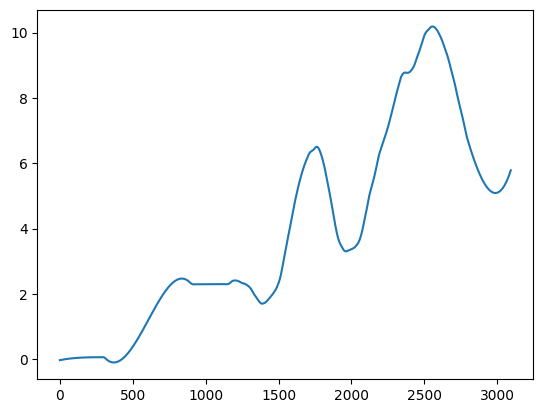

In [56]:
plt.plot( _ang)